In [26]:
import datetime as dt
import warnings
from datetime import datetime, timedelta
from math import sqrt
from time import sleep

import joblib
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import xgboost as xgb
from pandas import DataFrame, Series
from scipy import stats
from shapely.geometry import Point, Polygon
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import (ExtraTreesRegressor, GradientBoostingRegressor,
                              RandomForestRegressor)
from sklearn.decomposition import PCA
from sklearn.linear_model import (ElasticNet, HuberRegressor, Lasso,
                                  LinearRegression, Ridge, SGDRegressor)
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.model_selection import (GridSearchCV, KFold, RandomizedSearchCV,
                                     StratifiedKFold, cross_val_score,
                                     train_test_split, cross_validate)
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import FeatureUnion, Pipeline, make_pipeline
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from xgboost import XGBRegressor

# from dython.nominal import associations
import hdbscan
import mplleaflet
import shap
from catboost import CatBoostRegressor, Pool
from IPython.core.interactiveshell import InteractiveShell
from pipeline import clusterer, averager, FeatureSelector
# from lightgbm.sklearn import LGBMRegressor
import eli5
from eli5.sklearn import PermutationImportance

warnings.simplefilter(action='ignore', category=FutureWarning)
InteractiveShell.ast_node_interactivity = "all"


In [42]:
#### Read Pickled dataframes ############
df_train = pd.read_pickle('df_train.pkl')
df_test = pd.read_pickle('df_test.pkl')

In [45]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7068 entries, Order_No_19248 to Order_No_1603
Data columns (total 44 columns):
User Id                                     7068 non-null object
Vehicle Type                                7068 non-null object
Platform Type                               7068 non-null float16
Personal or Business                        7068 non-null int8
Placement - Day of Month                    7068 non-null uint16
Placement - Weekday (Mo = 1)                7068 non-null uint16
Placement - Time                            7068 non-null int16
Confirmation - Day of Month                 7068 non-null uint16
Confirmation - Weekday (Mo = 1)             7068 non-null uint16
Confirmation - Time                         7068 non-null int16
Arrival at Pickup - Day of Month            7068 non-null uint16
Arrival at Pickup - Weekday (Mo = 1)        7068 non-null uint16
Arrival at Pickup - Time                    7068 non-null int16
Pickup - Day of Month              

In [46]:
df_train['PrepTime'] = df_train['Pickup - Time'] - df_train['Arrival at Pickup - Time']
df_test['PrepTime'] = df_test['Pickup - Time'] - df_test['Arrival at Pickup - Time']



In [28]:
# ## Drop columns
drop_columns = []

additional_cols = ['Temperature', 'Precipitation in millimeters' 
#                    , 'geometric_mean_travel_time', 'mean_travel_time' 
                   ,'geometric_standard_deviation_travel_time', 'standard_deviation_travel_time']

drop_columns_train = ['Rider Id', 'pickup', 'destination', 'Vehicle Type'
                      , 'Arrival at Destination - Time', 'Arrival at Destination - Day of Month'
                      , 'Arrival at Destination - Weekday (Mo = 1)','dstid','sourceid', 'dow'
#                       , 'Pickup - Time_hour' 
                     ] + additional_cols

drop_columns_test = ['Rider Id', 'pickup', 'Vehicle Type',
                     'destination','dstid','sourceid', 'dow', 'Pickup - Time_hour'] + additional_cols

df_train = df_train.drop(drop_columns_train, axis=1)
df_test = df_test.drop(drop_columns_test, axis=1)

lable = df_train.pop('Time from Pickup to Arrival')

In [30]:
## Fill inn missing values
df_train = df_train.fillna(df_train.median())
df_test = df_test.fillna(df_train.median())

In [31]:
## Add the names of features created in the pipeline to the selected features list
selected_features=[
           'Distance (KM)', 
           'No_Of_Orders', 
           'Age', 
           'Average_Rating',
           'No_of_Ratings', 
           'mean_travel_time',
           'pickup_cluster',
           'dropoff_cluster',
           'trip_cluster',
           'PrepTime', 
#            'pickup_avg',
#            'confirmation_cluster',  
#            'Temperature',
#            'Precipitation in millimeters', 
#            'geometric_standard_deviation_travel_time',
#            'pickup_avg'
#            'Pickup Lat', 'Pickup Long'                   
#            'standard_deviation_travel_time', 
#            'Destination Lat',
#            'Destination Long', 
#            'Arrival at Pickup - Time',
#            'Arrival at Pickup - Day of Month',
#            'Placement - Day of Month',
#            'Placement - Weekday (Mo = 1)',
#            'Placement - Time_hour',
#            'Personal or Business', 
#            'Confirmation - Day of Month',
#            'Confirmation - Weekday (Mo = 1)', 
#            'Confirmation - Time_hour', 
#            'Arrival at Pickup - Weekday (Mo = 1)',
#            'Arrival at Pickup - Time_hour',
#            'Pickup - Day of Month', 
#            'Pickup - Time',
#            'Pickup - Weekday (Mo = 1)',
#            'pickup_ID', 
#            'destination_ID', 
#            'Dropoff_avg',
#            'Confirmation - Time',
#            'geometric_mean_travel_time',
]

params_dict = {
     'n_jobs': -1
   , 'min_child_weight': 5
   , 'learning_rate': 0.1
   , 'max_depth': 3
   , 'n_estimators': 500
   , 'scoring': 'neg_mean_squared_error'
   , 'random_state': 3
   , 'gamma':0}

preprocess = Pipeline([
    ('Pickup_clusterer', clusterer(min_cluster_size=20, columns=['Pickup Lat', 'Pickup Long', 'Pickup - Weekday (Mo = 1)', 'Pickup - Time'], name= 'pickup_cluster')),
    ('Dropoff_clusterer', clusterer(min_cluster_size=20, columns=['Destination Lat', 'Destination Long'], name= 'dropoff_cluster')),
    ('Trip_clusterer', clusterer(min_cluster_size=10, columns=['Distance (KM)', 'Pickup Lat', 'Pickup Long', 'Destination Lat', 'Destination Long'], name='trip_cluster')),
    ('Confirmation_clusterer', clusterer(min_cluster_size=20, columns=['Confirmation - Day of Month', 'Confirmation - Weekday (Mo = 1)', 'Confirmation - Time_hour','Confirmation - Time'], name='confirmation_cluster')),
    ('Pickup_avg', averager(cluster_col=['pickup_cluster'], name='pickup_avg', avg_col='mean_travel_time')), 
    ('featureSelector', FeatureSelector(all_features=df_train.columns.tolist(), selected_features=selected_features ))    
])

my_pipeline= Pipeline([
    ('preprocess', preprocess),
    ('Estimator', XGBRegressor(**params_dict)) 
])

## Cross-validate

In [22]:
output = cross_validate(my_pipeline, df_train, lable, cv=3, scoring='neg_mean_squared_error', n_jobs=-1, return_estimator=True)
scores = output['test_score']
print('Mean Absolute Error %2f' %sqrt(-1 * scores.mean()))

Mean Absolute Error 748.995995


In [32]:
# Fit model
pipe = my_pipeline.fit(df_train, lable)

[13:20:29] WARNING: /usr/local/miniconda/conda-bld/xgboost_1566327371504/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


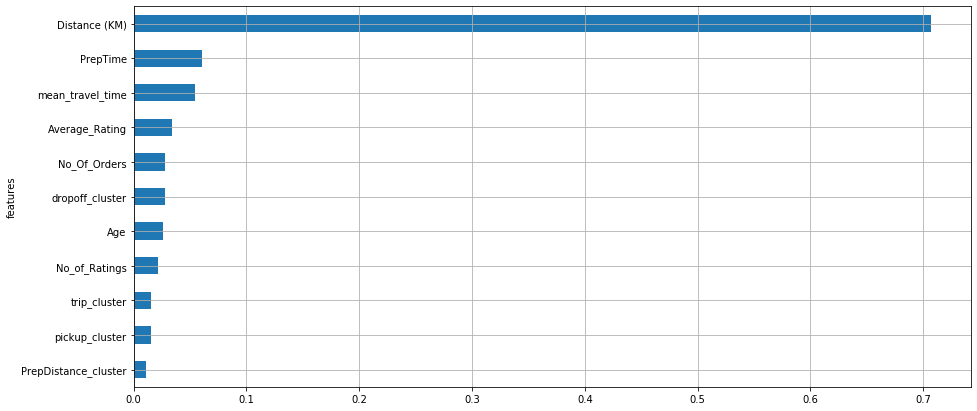

In [8]:
feature_importance = pd.DataFrame(list(zip(preprocess.named_steps['featureSelector'].selected_features, pipe.named_steps["Estimator"].feature_importances_)), columns=['features', 'importance'])
feature_importance.set_index('features', drop=True, inplace=True)
feature_importance.sort_values(by='importance', ascending=True, inplace=True)
feature_importance.plot(kind='barh', legend=False, grid=True, figsize=[15,7]);

# Submit

In [33]:
result = pipe.predict(df_test)
ids = df_test.index
submit = pd.DataFrame({'Order_No':ids,'Time from Pickup to Arrival':result.astype(int)}).set_index('Order_No')
submit.to_csv('submit.csv')
print ('Done saving!')

Done saving!


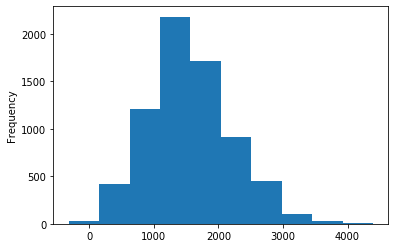

In [37]:
submit['Time from Pickup to Arrival'].plot(kind='hist', BINS)

### Shap
Måtte downgrade til 0.31.0

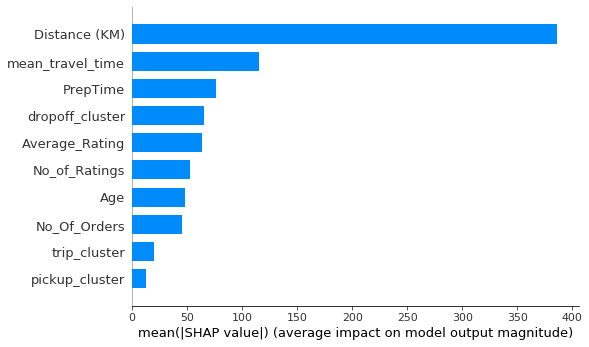

In [38]:
# Make graph dataset for shapley
df_test_ = preprocess.transform(df_train)
explainer = shap.TreeExplainer(my_pipeline.named_steps['Estimator'])
shap_values = explainer.shap_values(df_test_)
shap.summary_plot(shap_values, df_test_, plot_type="bar")

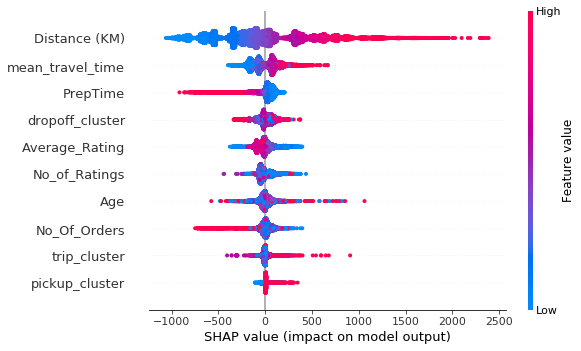

In [39]:
shap.summary_plot(shap_values, df_test_)

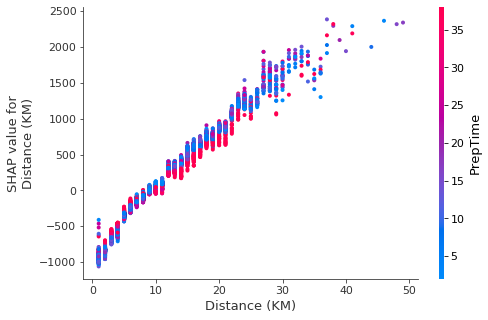

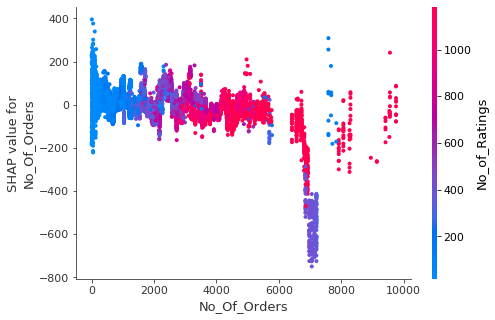

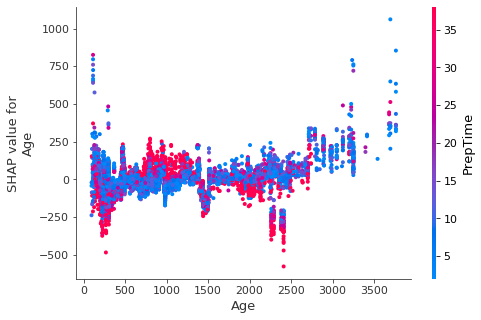

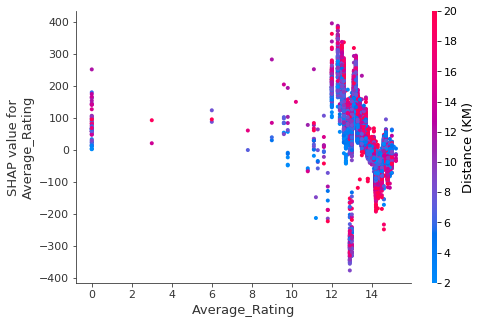

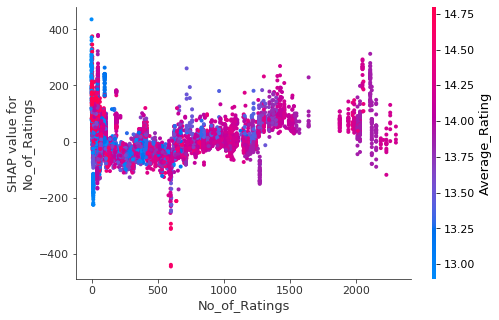

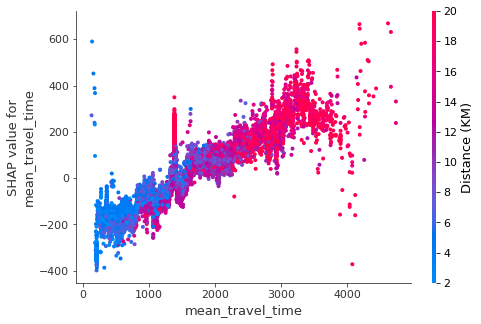

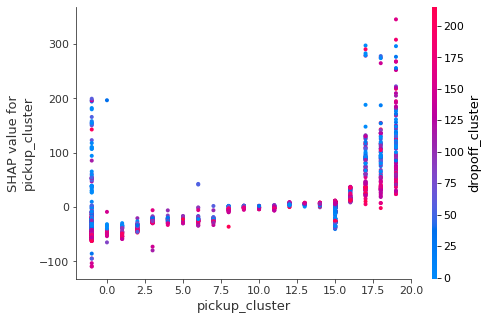

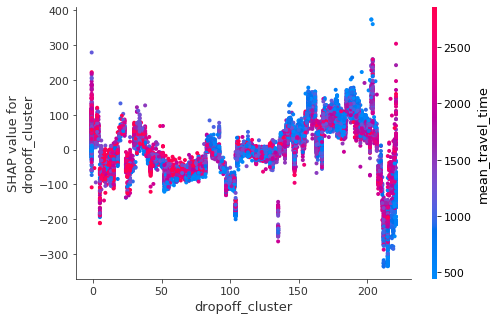

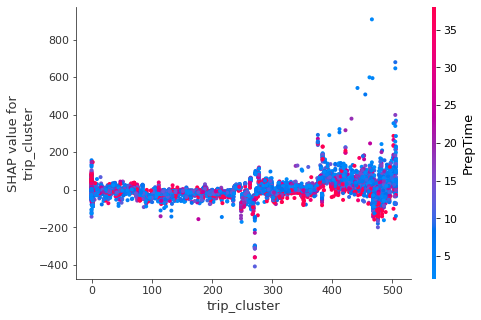

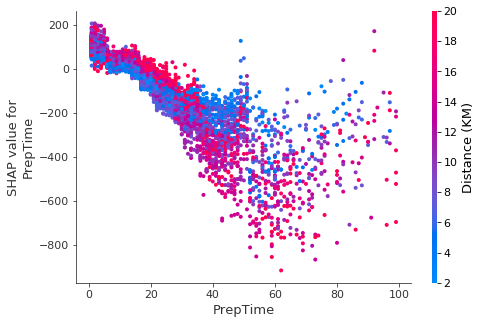

In [40]:
# plot pairwise shapley graphs

for name in df_test_.columns:
    shap.dependence_plot(name, shap_values, df_test_, display_features=df_test_)

## Grid Search

In [28]:
params = {
 'Estimator__gamma': [0,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1]        
 }

grid = GridSearchCV(estimator=my_pipeline, param_grid= params, scoring='neg_mean_squared_error', n_jobs=-1, cv=3)
grid.fit(df_train, lable)

[14:33:11] WARNING: /usr/local/miniconda/conda-bld/xgboost_1566327371504/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('preprocess',
                                        Pipeline(memory=None,
                                                 steps=[('Pickup_clusterer',
                                                         clusterer(columns=['Pickup '
                                                                            'Lat',
                                                                            'Pickup '
                                                                            'Long',
                                                                            'Pickup '
                                                                            '- '
                                                                            'Weekday '
                                                                            '(Mo '
                                  

In [29]:
print ('Best score = %s' %sqrt(-1 * grid.best_score_))
print ('Best paramter combination = ', grid.best_params_)

Best score = 757.8627569245855
Best paramter combination =  {'Estimator__gamma': 0}


In [ ]:
params = {
#          'Pickup_clusterer__min_cluster_size': [20, 60, 80],
#          'Dropoff_clusterer__min_cluster_size': [20, 60, 80],
#          'Trip_clusterer__min_cluster_size': [10, 20],
         'Estimator__max_depth': [2, 3, 4, 7],
         'Estimator__n_estimators': [50, 200, 400],
         'Estimator__min_child_weight': [1, 2],
         'Estimator__learning_rate': [0.1, 0.01, 0.5],
    }

grid = GridSearchCV(estimator=my_pipeline, param_grid= params, scoring='neg_mean_squared_error', n_jobs=-1, cv=5)
grid.fit(df_train, lable)

In [ ]:
print ('Best score = %s' %sqrt(-1 * grid.best_score_))
print ('Best paramter combination = ', grid.best_params_)

In [ ]:
pred = grid.predict(df_test)
print ('rmse score = %s' %sqrt(-1 * pred.best_score_))

### grid serach over models

In [ ]:
## XGBoost gjør det best

params_grid = [
    {'Estimator' : [RandomForestRegressor()]},
    {'Estimator' : [ExtraTreesRegressor()]},
    {'Estimator' : [GradientBoostingRegressor()]},
    {'Estimator' : [XGBRegressor()]},
    {'Estimator' : [ElasticNet()]},
    {'Estimator' : [LinearRegression()]},
    {'Estimator' : [HuberRegressor()]},
]
grid = GridSearchCV(estimator=my_pipeline, param_grid= params_grid, scoring='neg_mean_squared_error'
                    , n_jobs=-1, cv=3, verbose=15)

grid.fit(df_train, lable)

print ('Best score = %s' %sqrt(-1 * grid.best_score_))
print ('Best paramter combination = ', grid.best_params_)

## Plotting

In [ ]:
## Correlation
nominal_columns = list(df_train.select_dtypes(exclude=["number"]).columns)
associations(df_train,
             nominal_columns=nominal_columns,
             figsize=(25,9),
             theil_u=True)

In [ ]:
a, b = zip(*hexss['features'][0]['geometry']['coordinates'][0])

In [ ]:
coords = hexss['features'][0]['geometry']['coordinates'][0]
df_plot = df_train.sample(500)
#plt.hold(True)
#plt.plot(df_plot['Destination Long'], df_plot['Destination Lat'], 'r.')
#plt.plot(df_plot['Pickup Long'], df_plot['Pickup Lat'], 'b.')
plt.plot(a,b)
# Create the map. Save the file to basic_plot.html. _map.html is the default
# if 'path' is not specified
#mplleaflet.show(path=mapfile)
mplleaflet.display()